In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
start_dt = '2000-01-01'
end_dt = '2020-03-01'
ticker = 'MSFT' 
interval = '1d'

In [3]:
data = yf.download(tickers = ticker,
                  interval = interval,
                   start=start_dt, 
                   end=end_dt)

[*********************100%***********************]  1 of 1 completed


In [4]:
close_col_index = list(data.columns).index('Close')
data_len = data.shape[0]

In [5]:
ret_data = pd.DataFrame({'dt': data.index[1:data_len],
                         'close': data.iloc[1:data_len, close_col_index].values,
                         'close_lag': data.iloc[0:data_len-1, close_col_index].values,
                         'return': (data.iloc[1:data_len, close_col_index].values / 
                                    data.iloc[0:data_len-1, close_col_index].values) - 1 ,
                        })

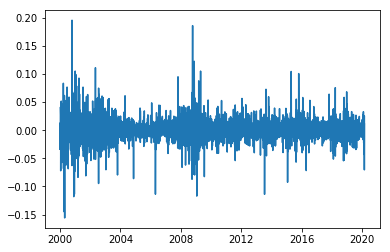

In [14]:
x = ret_data['dt']
y = ret_data['return']
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()